In [1]:
from numpy import loadtxt
import string
import matplotlib
import matplotlib.pyplot as plt
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
from astropy.io import fits
import glob
import os
from matplotlib import cm
from PIL import Image, ImageOps
from skimage import data, color
#from skimage.transform import rescale, resize, downscale_local_me
# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

<h1> Msssim function definitions </h1>

In [2]:
import numpy

def gaussian2(size, sigma):
    """Returns a normalized circularly symmetric 2D gauss kernel array
    
    f(x,y) = A.e^{-(x^2/2*sigma^2 + y^2/2*sigma^2)} where
    
    A = 1/(2*pi*sigma^2)
    
    as define by Wolfram Mathworld 
    http://mathworld.wolfram.com/GaussianFunction.html
    """
    A = 1/(2.0*numpy.pi*sigma**2)
    x, y = numpy.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = A*numpy.exp(-((x**2/(2.0*sigma**2))+(y**2/(2.0*sigma**2))))
    return g

def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x, y = numpy.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = numpy.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

In [3]:
import sys
import numpy
from scipy import signal
from scipy import ndimage
def ssim(img1, img2, cs_map=False):
    """Return the Structural Similarity Map corresponding to input images img1 
    and img2 (images are assumed to be uint8)
    
    This function attempts to mimic precisely the functionality of ssim.m a 
    MATLAB provided by the author's of SSIM
    https://ece.uwaterloo.ca/~z70wang/research/ssim/ssim_index.m
    """
    img1 = img1.astype(numpy.float64)
    img2 = img2.astype(numpy.float64)
    size = 11
    sigma = 1.5
    window = fspecial_gauss(size, sigma)
    K1 = 0.01
    K2 = 0.03
    L = 255 #bitdepth of image
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    mu1 = signal.fftconvolve(window, img1, mode='valid')
    mu2 = signal.fftconvolve(window, img2, mode='valid')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = signal.fftconvolve(window, img1*img1, mode='valid') - mu1_sq
    sigma2_sq = signal.fftconvolve(window, img2*img2, mode='valid') - mu2_sq
    sigma12 = signal.fftconvolve(window, img1*img2, mode='valid') - mu1_mu2
    if cs_map:
        return (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2)), 
                (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        return ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2))

def msssim(img1, img2):
    """This function implements Multi-Scale Structural Similarity (MSSSIM) Image 
    Quality Assessment according to Z. Wang's "Multi-scale structural similarity 
    for image quality assessment" Invited Paper, IEEE Asilomar Conference on 
    Signals, Systems and Computers, Nov. 2003 
    
    Author's MATLAB implementation:-
    http://www.cns.nyu.edu/~lcv/ssim/msssim.zip
    """
    level = 5
    weight = numpy.array([0.0448, 0.2856, 0.3001, 0.2363, 0.1333])
    downsample_filter = numpy.ones((2, 2))/4.0
    im1 = img1.astype(numpy.float64)
    im2 = img2.astype(numpy.float64)
    mssim = numpy.array([])
    mcs = numpy.array([])
    for l in range(level):
        ssim_map, cs_map = ssim (im1, im2, cs_map=True)
        mssim = numpy.append (mssim, ssim_map.mean())
        mcs = numpy.append (mcs, cs_map.mean())
        filtered_im1 = ndimage.filters.convolve(im1, downsample_filter, 
                                                mode='reflect')
        filtered_im2 = ndimage.filters.convolve(im2, downsample_filter, 
                                                mode='reflect')
        im1 = filtered_im1[::2, ::2]
        im2 = filtered_im2[::2, ::2]
    #print (mcs[0:level-1]**2)
    #print (weight[0:level-1]) 
    return (numpy.prod(mcs[0:level-1]**weight[0:level-1])*
                    (mssim[level-1]**weight[level-1]))


In [4]:
import math
def make_grid (count, index, cols):
    if (count >= 10):
        #index_col = (index % cols) + 1
        #index_row = (index / cols) + 1
        total_rows = math.ceil(count / cols)
        total_cols = cols
        #options = str (total_rows) + str (total_cols) + 
        return total_rows,total_cols
    else:
        total_rows = math.ceil(count / cols)
        total_cols = cols
        #options = str (total_rows) + str (total_cols) + 
        return total_rows,total_cols    

In [5]:
def ssim_plot_images (original_image, images):
    maps = []
    original_data = numpy.asarray (original_image)
    fil_data = []
    import pylab
    try:
        from PIL import Image
        for image in images:    
            img = numpy.asarray(image)
            fil_data.append (img)
    except Exception (e):
        e = 'Cannot load images' + str(e)
        print >> sys.stderr, e
    ssimRes = []
    msSimRes = []
    best_index = -1
    best = 0
    for ind, d in enumerate(fil_data):
        original_data = (original_data/original_data.max())*255
        d = (d/d.max()) * 255
        ssim_map = ssim(original_data, d)
        ms_ssim = msssim(original_data, d)
        if (ms_ssim > best):
            best = ms_ssim
            best_index = ind
        #print (original_data [original_data != 0].shape)
        ssimRes.append (ssim_map)
        msSimRes.append (ms_ssim)
    pylab.figure(figsize=(8, 6), dpi=300)
    #options = '1' + str (len (paths)) + '1'
    r, c = make_grid (len (images) + 1, 1, 3)
    #print (r, ' ', c)
    pylab.subplot(r, c , 1)
    plt.axis('off')
    pylab.title('Original')
    pylab.imshow(original_data, interpolation='nearest')
    for i in range (len (images)):    
        #options = '1' + str (len (paths)) + str (i + 2)
        pylab.subplot(r, c, i + 2)
        pylab.imshow(fil_data [i], interpolation='nearest')
        #pylab.subplot(133)
        s = "{value:.2f}"
        s = s.format(value = msSimRes[i])
        title = s
        pylab.title(s)
        #pylab.title('SSIM Map\n SSIM: %f\n MSSSIM: %f' % (ssimRes[i].mean(), msSimRes[i]))
        plt.axis('off')
        #pylab.imshow(ssim_map, interpolation='nearest')
    rand_ind = np.random.randint(1000000)    
    filename = original_path.split ('/')[-1].replace ('.fits','.png')
    filename = str (rand_ind) + filename
    pylab.savefig('datasets/msim_top_15_filaments/' + filename)
    return best_index
    #pylab.show()

In [6]:
def ssim_plot (original_path, paths, options):
    maps = []
    original_data = fits.open (original_path)
    original_data = numpy.asarray (original_data[0].data)
    fil_data = []
    import pylab
    try:
        from PIL import Image
        for path in paths:    
            data = fits.open(path)
            fil_map = data[0].data
            img = numpy.asarray(fil_map)
            fil_data.append (fil_map)
    except Exception (e):
        e = 'Cannot load images' + str(e)
        print >> sys.stderr, e
    ssimRes = []
    msSimRes = []
    best_index = -1
    best = 0
    for ind, d in enumerate(fil_data):
        original_data = (original_data/original_data.max())*255
        d = (d/d.max()) * 255
        ssim_map = ssim(original_data, d)
        ms_ssim = msssim(original_data, d)
        if (ms_ssim > best):
            best = ms_ssim
            best_index = ind
        #print (original_data [original_data != 0].shape)
        #ssimRes.append (ssim_map)
        #msSimRes.append (ms_ssim)
    #pylab.figure(figsize=(8, 6), dpi=300)
    #options = '1' + str (len (paths)) + '1'
    #r, c = make_grid (len (paths) + 1, 1, 3)
    #print (r, ' ', c)
    #pylab.subplot(r, c , 1)
    #plt.axis('off')
    #pylab.title('Original')
    #pylab.imshow(original_data, interpolation='nearest')
    #for i in range (len (paths)):    
        #options = '1' + str (len (paths)) + str (i + 2)
    #    pylab.subplot(r, c, i + 2)
    #    pylab.imshow(fil_data [i], interpolation='nearest')
        #pylab.subplot(133)
    #    s = "{value:.2f}"
    #    s = s.format(value = msSimRes[i])
    #    title = s
     #   pylab.title(s + '   '+ options [i])
        #pylab.title('SSIM Map\n SSIM: %f\n MSSSIM: %f' % (ssimRes[i].mean(), msSimRes[i]))
     #   plt.axis('off')
        #pylab.imshow(ssim_map, interpolation='nearest')
    #filename = original_path.split ('/')[-1].replace ('.fits','.png')
    #pylab.savefig('datasets/msim/' + filename)
    #pylab.close()
    return best_index
    #pylab.show()

<h1> Filament finding code </h1>

<h3> filament finding based on rht from Hershel column density data </h3>

In [7]:
import os
import glob
dirs = [d.split ('\\')[1] for d in glob.glob ('SUPRHT/OUTPUT*COLD_DEN')]
print (dirs)
filaments = {}
for d in dirs:
    cur_folder = 'SUPRHT/' + d
    files = [f.split ('\\')[1] for f in glob.glob (cur_folder+'/*') if f.count ('THETA') == 0]
    #G0.02+18.02_PO_3_BETA2_colden_SUPRHT_K13_BAR1.fits
    print ('file:',files[0])
    for file in files:
        fil = file.split ('_SUPRHT_')[0]
        print (fil)
        if (fil in filaments):
            path = cur_folder + '/' + file
            opt = file.split ('_') [-2:]
            opt[1] = opt[1].replace ('.fits','')
            opt = ' '.join (opt)
            print (opt)
            data = fits.open(path)
            #fil_map = data[0].data 
            filaments[fil].append ((path,opt))
            #filaments[fil].append (fil_map)
            #print (fil_map)
        else:
            path = cur_folder + '/' + file
            data = fits.open(path)
            fil_map = data[0].data 
            filaments[fil] = []
            #filaments[fil].append (fil_map)
            opt = file.split ('_') [-2:]
            opt[1] = opt[1].replace ('.fits','')
            opt = ' '.join (opt)
            print (opt)
            filaments[fil].append ((path,opt))
    #print (files)
    print (len (fil))
    #break

#G0.02+18.02_160__SUPRHT_K5_BAR1.fits

[]


<h3> filament finding based on rht from Hershel intensity data </h3>

In [27]:
def find_best_msim_maps (): 
    i = 0
    best_msims = []
    for key, v in filaments.items ():
        original_path = 'datasets/colden/' + key + '.fits'     
        items = [k for k,v1 in v]
        mask = fits.open (items [1])
        opts = [v1 for k,v1 in v]
        best_msims.append (ssim_plot (original_path, items, opts))
        i+=1
    return best_msims    

In [28]:
best_msims = find_best_msim_maps()

In [29]:
import os
import glob
from matplotlib import cm
from PIL import Image, ImageOps
from skimage import data, color
import subprocess
from skimage.transform import rescale, resize, downscale_local_mean

def find_masks_and_images ():
    #best_msims = find_best_msim_maps()
    images_all = []
    masks_all = []
    pil_all =  []
    i = 0
    os.chdir('C:/Users/NU/Documents/dana_collaboration_project')
    for key, v in filaments.items ():
        #print (key)
        #wd = os.getcwd()
        # print (wd)
        original_path = 'datasets/colden/' + key + '.fits'     
        items = [k for k,v1 in v]
        mask = fits.open (items [best_msims[i]])
        #import os
        fname = items [best_msims[i]].split('/')[-1]
        #wd = os.getcwd()
        #print (wd)
        #print (items [best_msims[i]])
        #os.chdir("/")
        #wd = wd.replace ('\\','/')
        #command = 'copy ' + wd + '/' + items [best_msims[i]] + ' ' + wd + '/dataset_best/' + fname
        #command = command.replace ('/','\\')
        #print (command)
        #from shutil import copyfile
        
        #copyfile(items [best_msims[i]], 'dataset_best/' + fname)
        #copyfile (original_path, 'dataset_best/' + original_path.split ('/')[-1])
        #angles_file = items [best_msims[i]].replace ('_SUPRHT','_SUPRHT_THETA')
        #copyfile (angles_file, 'dataset_best/' + angles_file.split ('/')[-1])
        
        #subprocess.call(command)
        #os.chdir(wd)
        #os.popen('copy ' + items [best_msims[i]] + ' dataset_best/' + fname)
        #print (fname)
        #break
        opts = [v1 for k,v1 in v]
        image_f = fits.open (original_path)
        image_d = np.array (image_f[0].data).astype('float32')
        image_dd = (image_d / image_d.max()) *  255.0;
        image_d = Image.fromarray(image_dd)
        newSize = (256,256)
        image_p = image_d.resize(newSize)
        image_f = np.array (image_p).astype ('float32')
        image_f = (image_f / image_f.max()) * 255.0;
        image_f = image_f.clip(min = 0)
        #print ('max:',image_f.max())
        image_dd = image_f[image_f != 0]
        #print (image_dd)
        #plt.imshow (image_f)

        mask_d = np.array (mask[0].data)
        mask_d = (mask_d / mask_d.max())*255
        mask_p = Image.fromarray(mask_d)
        newSize = (256,256)
        mask_p = mask_p.resize(newSize)
        mask = np.array (mask_p)
        cnt = 0
        mm = mask.max()
        for i1 in range (256):
            for j in range (256):
                if (mask[i1][j] > 0.15 * mm):
                    #print (mask[i][j])
                    cnt  = cnt + 1
                    mask[i1][j] = 1
                else:
                    mask[i1][j] = 0
        #print ('max_mask:',mask.max())
        mask = mask.tolist()
        masks_all.append (mask)
        stacked_img = np.stack((image_f,)*3, axis=-1)
        images_all.append (stacked_img.tolist())
        i+=1
    return images_all, masks_all

In [33]:
images_all, masks_all = find_masks_and_images()

In [34]:
print (best_msims)

[0, 1, 2, 4, 4, 1, 5, 0, 0, 3, 4, 1, 1, 0, 5, 1, 5, 1, 3, 0, 2, 0, 3, 1, 1, 0, 3, 0, 1, 1, 0, 0, 2, 3, 1, 1, 4, 3, 0, 1, 4, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 3, 1, 3, 0, 1, 1, 0, 2, 0, 0, 1, 0, 1, 0, 2, 4, 1, 3, 3, 4, 4, 1, 0, 4, 4, 5, 4, 1, 1, 0, 0, 4, 4, 3, 1, 1, 3, 3, 2, 0, 3, 0, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1]


In [35]:
def connected_component_label(image, number_of_components):
    # Getting the input image
    img = np.array (image,dtype=np.uint8)
    img2 = np.zeros (img.shape)
    num_labels, labels = cv2.connectedComponents(img)
    #plt.imshow (labels)
    ulabels = np.unique (labels)
    #print (ulabels)
    masks = np.zeros ((256,256,ulabels.shape[-1]))
    #print (masks.shape)
    sizes = np.zeros (ulabels.shape [-1])
    
    for i,label in enumerate(ulabels):
        if (i == 0):
            continue
        indices = np.where (labels == label)
        sizes [i] = indices[0].shape [-1]
        #print ('sz:', sizes[i])
    mval = np.mean (sizes) 
    #print ('mean is :', mval)
    
    for i,label in enumerate(ulabels):
        indices = np.where (labels == label)
        if (sizes[i] <= mval):
            labels [labels == label] = 0
            sizes[i] = 0
            continue
    ulabel2 = []
    sizes2 = []
    for i,label in enumerate(ulabels):
        if (i == 0):
            continue
        if (sizes [i] > 0):
            sizes2.append (sizes[i])
            ulabel2.append (label)        
    ulabel2 = np.array (ulabel2)
    sizes2 = np.array (sizes2)
    arr1inds =sizes2.argsort()
    sizes2 = sizes2[arr1inds[::-1]]
    ulabel2 = ulabel2[arr1inds[::-1]]
    indl = min (ulabel2.shape[-1], number_of_components)
    sizes2 = sizes2[:indl]
    ulabel2 = ulabel2[:indl]
    #print ('szies:',sizes2)
    #print ('labels:',ulabel2)
    #masks = np.zeros ((256,256, min(10, ulabel2.shape[-1] - 1)))
    masks = np.zeros ((256,256,ulabel2.shape [-1]))
    for i,label in enumerate(ulabel2):
        indices = np.where (labels == label)
        for j in range (len (indices[0])):
            masks[indices[0][j],indices[1][j],i] = 1
    return masks       

<h3> simple test code for a component finding procedure</h3>

In [36]:
def plot_all_filaments (filaments):
    size = (256,256)
    gt_masks = np.zeros (size)
    all_masks_c = np.array (filaments)
    number_of_masks = all_masks_c.shape [-1]
    for i in range (256):
        for j in range (256):
            for k in range (number_of_masks): 
                if (all_masks_c[i, j , k] == 1):
                    gt_masks [i,j] = all_masks_c[i, j , k]
    return gt_masks            

(256, 256)


NameError: name 'all_masks' is not defined

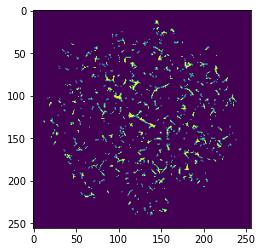

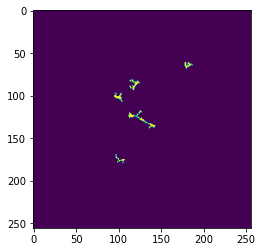

<Figure size 432x288 with 0 Axes>

In [37]:
mask = np.array(masks_all [13])
print (mask.shape)
image = masks_all [13]
#plt.hist (mask.flatten ())
figure = plt.figure (0)
plt.imshow (image)
figure2 = plt.figure (1)
masks = connected_component_label (mask, 5)
gt_mask_5 = plot_all_filaments (masks)
plt.imshow (gt_mask_5)
figure3 = plt.figure (2)
masks = connected_component_label (mask, 15)
masks = all_masks [13]
gt_mask = plot_all_filaments (masks)
plt.imshow (gt_mask)
figure = plt.figure (3)
oimage = np.array (images_all [13])
print (oimage.shape)
plt.imshow (oimage[:,:,0])
original_image = np.array (images_all [13])
results = model.detect([original_image], verbose=1)
r = results[0]
r ['masks'] = np.array (r['masks'])
gt_mask = plot_all_filaments (r['masks'])
figure = plt.figure (4)
plt.imshow (gt_mask)

In [38]:
all_masks_5 = []
all_masks_10 = []
for i in range (len (masks_all)):
    print (i)
    cur_masks = connected_component_label (masks_all[i], 5)
    cur_masks2 = connected_component_label (masks_all[i], 10)
    all_masks_5.append (cur_masks)
    all_masks_10.append (cur_masks2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


<h3> testing on a single map </h3>

In [39]:
size = (256,256)
gt_masks = np.zeros (size)
all_masks_c = np.array (all_masks [12])
number_of_masks = all_masks_c.shape [-1]
for i in range (256):
    for j in range (256):
        for k in range (number_of_masks): 
            if (all_masks_c[i, j , k] == 1):
                gt_masks [i,j] = all_masks_c[i, j , k]
#print (images_all[10])
plt.figure(0)
plt.imshow (images_all[12])
#print (np.array (images_all [0]).max())
#print (np.array (images_all [0]).min())
#plt.hist (np.array(masks_all[0]).flatten())
plt.figure(1)
plt.imshow (masks_all[12])
plt.figure(2)
plt.imshow (gt_masks)

NameError: name 'all_masks' is not defined

In [ ]:
for key, v in filaments.items ():
    #print (len (v))
    if (len (v) > 1 and i > 14):
        original_path = 'cc_fil/Herschel_data-20210927T210244Z-001/Herschel_data/maps/' + key + '_.fits'
        print (original_path)     
        items = [k for k,v1 in v]
        opts = [v1 for k,v1 in v]
        ssim_plot (original_path, items, opts)
        break

In [ ]:
i = 0
#options = ['OUTPUT', 'OUTPUT3', 'OUTPUT_13_1', 'OUTPUT_15_3', 'OUTPUT_21_3_COLD_DEN', 'OUTPUT_27_3', 'OUTPUT_31_3', 'OUTPUT_31_5', 'OUTPUT_5_1', 'OUTPUT_7_3', 'OUTPUT_9_1']
for key, v in filaments.items ():
    #print (len (v))
    if (len (v) > 1 and i > 14):
        original_path = 'cc_fil/Herschel_data-20210927T210244Z-001/Herschel_data/maps/' + key + '_.fits'
        print (original_path)     
        items = [k for k,v1 in v]
        opts = [v1 for k,v1 in v]
        ssim_plot (original_path, items, opts)
        break
        #data1 = fits.open(v [0])
        #data2 = fits.open(v [1])
        #fil_map1 = data1[0].data
        #fil_map2 = data2[0].data
        #print (v[0],v[1],key)
        #original_path = 'cc_fil/Herschel_data-20210927T210244Z-001/Herschel_data/maps/' + key + '_.fits'
        #data_o = fits.open (original_path)
        #data_o = data_o[0].data
        #plt.figure (1)
        #plt.imshow (data_o)
        #ssim_plot (v[0], v[1])
        #plt.figure(i)
        #i += 1
        #ssim_plot (v[0], v[1])
    i+=1   

<h1> RHT finding procedures </h1>

In [1]:
def find_rht (original_path, destination_root, K, B):
    filename = original_path.replace ('\\','/').split ('/')[-1].split ('fits')[0][0:-1]
    rht_path = destination_root + '/' + 'HERSHEL_' + str (K) + '_'+str (B) + '_COLD_DEN' + '/' + filename + '_SUPRHT_K' + str (K) + '_BAR' + str (B)
    return rht_path + '.fits'  

In [ ]:
def plot_filament (original_path, rht_path):
    plt.figure (0)
    fdata = fits.open (original_path)
    plt.imshow (fdata[0].data)
    plt.figure (1)
    fdata = fits.open (rht_path)
    plt.imshow (fdata[0].data)

In [24]:
import suprht
# file = 'SUPRHT/OUTPUT_21_3_COLD_DEN/G0.02+18.02_PO_3_BETA2_colden_SUPRHT_K21_BAR3.fits'
# file2 = 'datasets/colden/G0.02+18.02_PO_3_BETA2_colden.fits'
# #mask_file = 'cc_fil/353GHz_DR2015_GND_res7_MASK_G325.57_6.03.fits'
# dd=fits.open(file)
# #mask = fits.open(mask_file)
# map = dd[0].data
# #m = mask[0].data
# print (map[map > 1])
# plt.figure(0)
# #plt.subplot(121)
# #plt.axis('off')
# plt.imshow(map)
# #plt.subplot(122)
# #plt.imshow(m)
# plt.axis('off')
# #plt.savefig('example_mask.png')
# #a = np.expand_dims(map)
# plt.figure (1)
# fdata = fits.open (file2)
# plt.imshow (fdata[0].data)
files = glob.glob ('colden_18/*.fits')
i = 0
ks = 31
bw = 7
print (files)
for file in files[::-1]:
    print (file)
    rht_path = find_rht (file, 'SUPRHT', 31, 7)
    ndrizz = 101
    ntheta = 180
    Dict_size = 1
    N_ideal_bars = 10000
    smooth_rad_bitmap = bw
    sigma_gauss_edge_smooth = smooth_rad_bitmap + 0
    kernel_file = 'SUPRHT/'+ 'kernel_supRHT_K{}_B{}_Nd{}_Nt{}.fits'.format(ks, bw, ndrizz, ntheta)  #kernel_path + 'kernel_supRHT_K{}_B{}_Nd{}_Nt{}.fits'.format(ks, bw, ndrizz, ntheta)
    sigma_file =  'SUPRHT/' + 'map'+'_sigma_K{}_B{}_Nd{}_Nt{}_NBI{}.fits'.format(ks, bw, ndrizz, ntheta, N_ideal_bars) #sigma_path + 'map'+'_sigma_K{}_B{}_Nd{}_Nt{}_NBI{}.fits'.format(ks, bw, ndrizz, ntheta, N_ideal_bars)
    output_path = ''
    histogram_fraction = 0.75
    print (rht_path)
    RHT_output = suprht.main(file, kernel_file, ks, bw, ndrizz, ntheta, histogram_fraction, sigma_gauss_edge_smooth, smooth_rad_bitmap, output_path)
    #break
    i += 1
    #plot_filament (files [1], rht_path)

['colden_20\\_I_g_lon-1.207_lat19.1743_250x250.fits', 'colden_20\\_I_g_lon-2.3065_lat12.6256_291x291.fits', 'colden_20\\_I_g_lon-2.4096_lat15.4935_291x291.fits', 'colden_20\\_I_g_lon1.4742_lat20.9698_291x291.fits', 'colden_20\\_I_g_lon1.9025_lat-24.2939_250x250.fits', 'colden_20\\_I_g_lon1.9025_lat9.8597_250x250.fits']
colden_20\_I_g_lon1.9025_lat9.8597_250x250.fits
SUPRHT/HERSHEL_31_7_COLD_DEN/_I_g_lon1.9025_lat9.8597_250x250_SUPRHT_K31_BAR7.fits
SUPRHT/kernel_supRHT_K31_B7_Nd101_Nt180.fits
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  180                                                  
NAXIS2  =                   31                                                  
NAXIS3  =                   31                                                  
KERNSIZE=        

 [====================] 100%
Computing...
Files succesfully saved:	SUPERHT.fits	SUPERHT_THETA.fits	SUPERHT_SIGTHETA.fits	
colden_20\_I_g_lon-2.4096_lat15.4935_291x291.fits
SUPRHT/HERSHEL_31_7_COLD_DEN/_I_g_lon-2.4096_lat15.4935_291x291_SUPRHT_K31_BAR7.fits
SUPRHT/kernel_supRHT_K31_B7_Nd101_Nt180.fits
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  180                                                  
NAXIS2  =                   31                                                  
NAXIS3  =                   31                                                  
KERNSIZE=                   31 / Size of the kernel's side                      
BARWIDTH=                    7 / Width of Kernel Bar                            
NDRIZZ  =                  101 / Number of sub-pix

KeyboardInterrupt: 

(array([     0.,      0.,      0.,      0.,      0., 114921.,      0.,
             0.,      0.,      0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

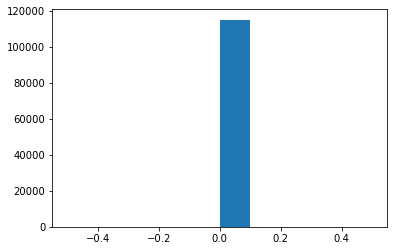

In [23]:
data = fits.open ('colden_19/_M_k_lon122.7322_lat12.691_339x339_smr27_wlen7_SUPRHT_K31_BAR7.fits')
data = data[0].data
plt.hist (np.array (data).flatten())

<h1> MASK RCNN training part </h1>

In [40]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [41]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [42]:
class FilamentDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "filament")
        
        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            #bg_color, shapes = self.random_image(height, width)
            bg_color = (0 , 0 , 0)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes = ['filament'])

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        #info = self.image_info[image_id]
        #bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        #image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        #image = image * bg_color.astype(np.uint8)
        #for shape, color, dims in info['shapes']:
        #    image = self.draw_shape(image, shape, dims, color)
        image = np.array (images_all [image_id])
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        return ['filament']
        #info = self.image_info[image_id]
        #if info["source"] == "shapes":
        #    return info["shapes"]
        #else:
        #    super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        #plt.imshow (masks_all [image_id])
        arr = np.array (masks_all [image_id])
        #for i in range (256):
        #    for j in range (256):
        #        if (arr [i][j] > 0):
        #            print (masks_all [image_id][i][j])
        #print (arr.shape)
        
        #OLD IMPL
        #mask = np.zeros([256, 256, 1], dtype=np.uint8)
        #mask [:,:,0] = arr
        
        #NEW IMPL
        #mask = connected_component_label (arr)
        mask = np.array (all_masks [image_id])
        count = mask.shape [-1]
        shapes = ['filament'] * count
        #print ('mask shape:',' ',mask.shape)
       # print ('class names:',' ',self.class_names)
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s) for s in shapes])
        #return mask.astype(np.bool), class_ids.astype(np.int32)
        cnt = 0
#         for i in range (256):
#             for j in range (256):
#                 if (mask [i][j] > 0):
#                     cnt = cnt + 1
        #print ('count is:',' ',cnt)   
        #print ('class_ids shape:',' ',class_ids.shape)
        return mask, class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes


In [43]:
# Training dataset
import random
#random.shuffle (images_all)
#print (len(images_all))
c = list(zip(images_all, masks_all, all_masks_10))
random.shuffle(c)
images_all, masks_all, all_masks = zip(*c)

dataset_train = FilamentDataset()
dataset_train.load_shapes(90, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()
# Validation dataset
dataset_val = FilamentDataset()
dataset_val.load_shapes(20, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [44]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
classes : [1 1 1 1 1 1 1 1 1 1]


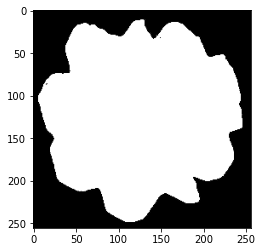

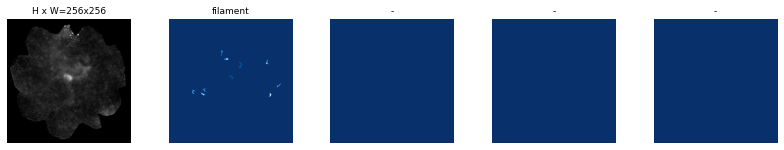

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes : [1 1 1 1 1 1 1 1 1 1]


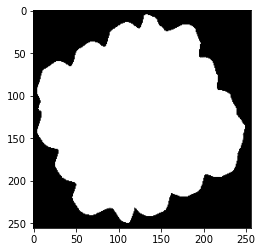

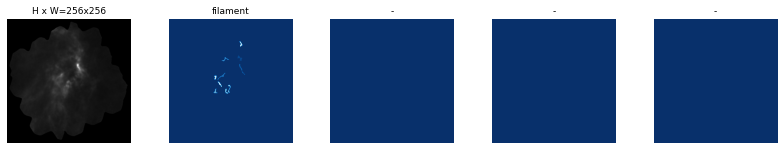

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes : [1 1 1 1 1 1 1 1 1 1]


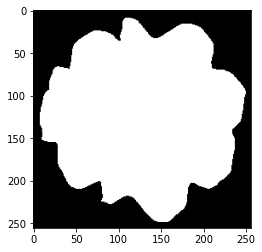

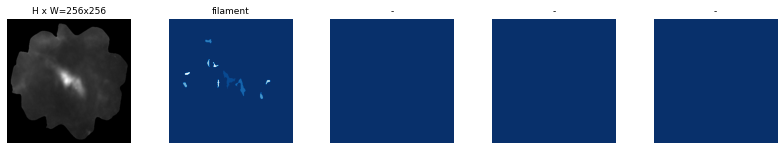

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes : [1 1 1 1 1 1 1 1 1 1]


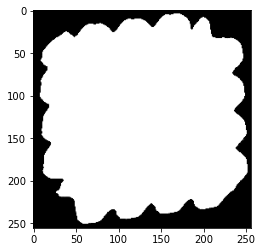

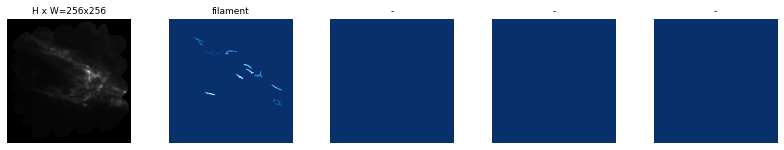

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes : [1 1 1 1 1 1 1 1 1 1]


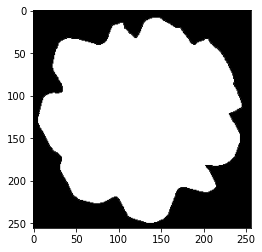

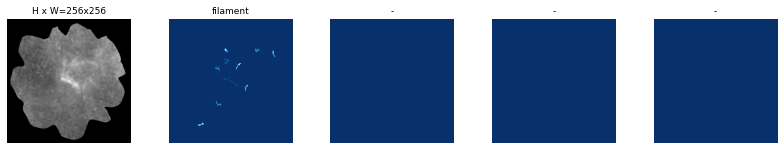

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes : [1 1 1 1 1 1 1 1 1]


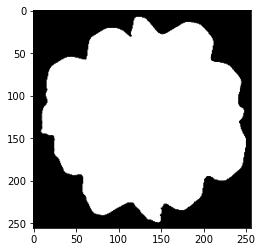

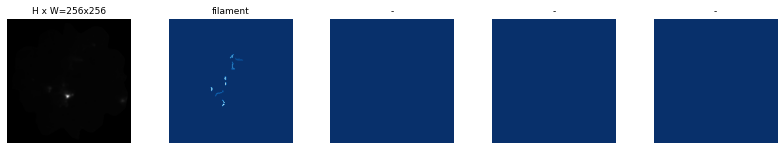

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes : [1 1 1 1 1 1 1 1 1 1]


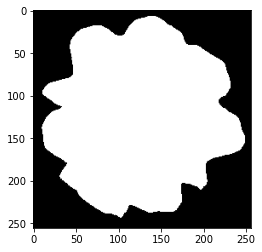

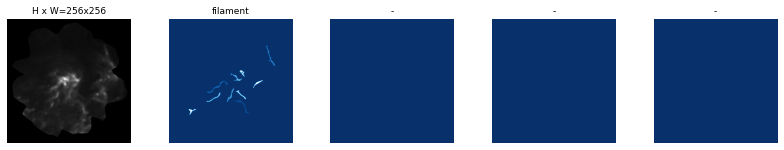

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes : [1 1 1 1 1 1 1 1 1 1]


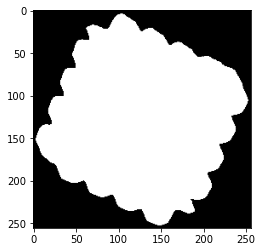

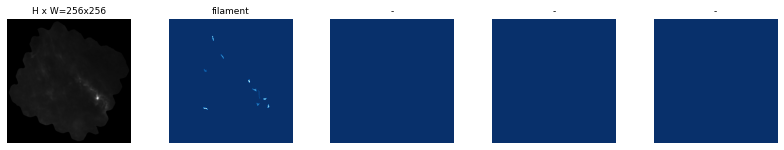

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes : [1 1 1 1 1 1 1 1 1 1]


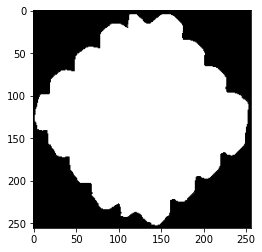

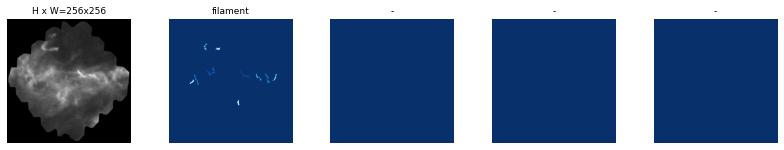

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


classes : [1 1 1 1 1 1 1 1 1]


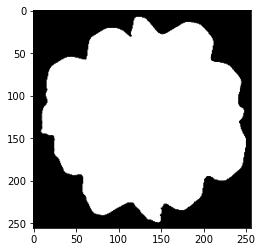

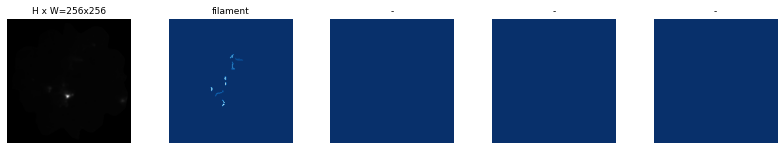

In [45]:
# Load and display random samples
print (dataset_train.image_ids)
image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('classes', ':' , class_ids)
    plt.imshow (image)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [46]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [47]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [48]:


# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')



Num GPUs Available:  1

Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\NU\Documents\dana_collaboration_project\logs\shapes20211223T1025\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_f

C:\Users\NU\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\NU\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_5:0", shape=(N

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 3.0880 - rpn_class_loss: 0.1915 - rpn_bbox_loss: 1.1093 - mrcnn_class_loss: 0.3630 - mrcnn_bbox_loss: 0.8833 - mrcnn_mask_loss: 0.5409

C:\Users\NU\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


100/100 [==============================] - 44s 316ms/step - batch: 49.5000 - size: 1.0000 - loss: 3.0880 - rpn_class_loss: 0.1915 - rpn_bbox_loss: 1.1093 - mrcnn_class_loss: 0.3630 - mrcnn_bbox_loss: 0.8833 - mrcnn_mask_loss: 0.5409 - val_loss: 2.7651 - val_rpn_class_loss: 0.1357 - val_rpn_bbox_loss: 0.8250 - val_mrcnn_class_loss: 0.5374 - val_mrcnn_bbox_loss: 0.7889 - val_mrcnn_mask_loss: 0.4780
Epoch 2/30
100/100 [==============================] - 17s 174ms/step - batch: 49.5000 - size: 1.0000 - loss: 2.6847 - rpn_class_loss: 0.1433 - rpn_bbox_loss: 0.9277 - mrcnn_class_loss: 0.3482 - mrcnn_bbox_loss: 0.7284 - mrcnn_mask_loss: 0.5370 - val_loss: 2.4848 - val_rpn_class_loss: 0.1382 - val_rpn_bbox_loss: 0.7509 - val_mrcnn_class_loss: 0.4282 - val_mrcnn_bbox_loss: 0.6608 - val_mrcnn_mask_loss: 0.5068
Epoch 3/30
100/100 [==============================] - 18s 177ms/step - batch: 49.5000 - size: 1.0000 - loss: 2.5809 - rpn_class_loss: 0.1338 - rpn_bbox_loss: 0.9040 - mrcnn_class_loss: 0.36

<h1> Inference MASK RCNN testing part </h1>

In [49]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead
Loading weights from  C:\Users\NU\Documents\dana_collaboration_project\logs\shapes20211223T1025\mask_rcnn_shapes_0030.h5
Re-starting from epoch 30


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   35.00000  max:  207.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
(256, 256)   (256, 256)   (256, 256)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0.

TypeError: Invalid shape (256, 256, 10) for image data

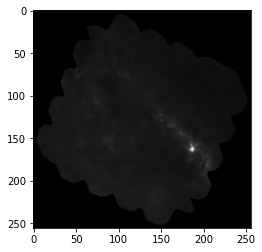

In [50]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
data = np.where (original_image == 1)
alpha = 0.6
color = [0] * 3
arr = original_image[:, :, 0] * (1 - alpha) + alpha * color[0] * 255
arr2 = original_image[:, :, 0]
mask =  gt_mask[:,:,0]
print (arr.shape, ' ', arr2.shape, ' ', mask.shape)    
#for c in range(3):
    
    #original_image[:, :, c] = np.where(original_image[:,:,0]== 1,
    #                          original_image[:, :, c] *
    #                          (1 - alpha) + alpha * color[c] * 255,
    #                           original_image[:, :, c])
#print (original_image.shape)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
print (original_image)
plt.imshow (original_image / 255.0)
plt.savefig ('file_saved.jpg')
plt.imshow (gt_mask / 255.0)
plt.savefig ('file_mask.jpg')
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

#image_d = Image.fromarray (original_image.astype('uint8'))
#newSize = (256,256)
#image_p = image_d.resize(newSize)
#jpg_image = 'file_saved.jpg'
#print (jpg_image)
#image_p = image_p.convert ('RGB')
#image_p.save (jpg_image)
#plt.figure()
#f, axarr = plt.subplots(2,1) 
#axarr[0].imshow(original_image)


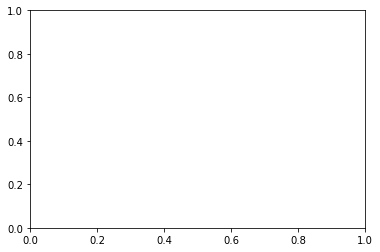

In [51]:
plt.clf()
plt.cla()

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (6,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (6, 4)                min:   70.00000  max:  228.00000  int32
gt_mask                  shape: (256, 256, 6)         min:    0.00000  max:    1.00000  float64
GT: 6
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
shape is : 9
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   72.00000  max:  226.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)    

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   35.00000  max:  207.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
shape is : 17
[[False False False ... False False False]
 [False False False ... False False False]
 [False False Fal

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   43.00000  max:  223.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)    

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   74.00000  max:  192.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
shape is : 16
[[False False False ... False False False]
 [False False False ... False False False]
 [False False Fal

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   23.00000  max:  167.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)    

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   15.00000  max:  186.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
shape is : 15
[[False False False ... False False False]
 [False False False ... False False False]
 [False False Fal

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   33.00000  max:  228.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)    

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   29.00000  max:  227.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
shape is : 19
[[False False False ... False False False]
 [False False False ... False False False]
 [False False Fal

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   49.00000  max:  217.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)    

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   30.00000  max:  200.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
shape is : 11
[[False False False ... False False False]
 [False False False ... False False False]
 [False False Fal

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   15.00000  max:  211.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)    

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   29.00000  max:  222.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
shape is : 11
[[False False False ... False False False]
 [False False False ... False False False]
 [False False Fal

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   35.00000  max:  193.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)    

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   16.00000  max:  222.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
shape is : 14
[[False False False ... False False False]
 [False False False ... False False False]
 [False False Fal

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:   23.00000  max:  195.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  float64
GT: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)    

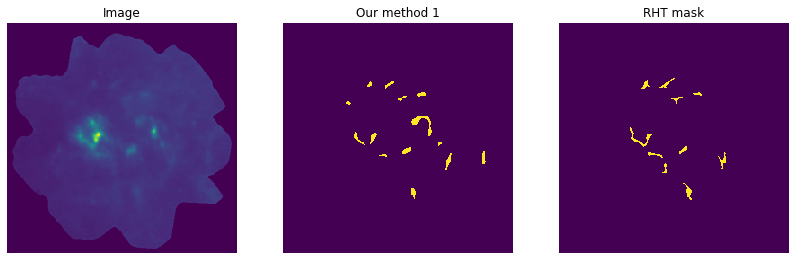

In [63]:
os.chdir('C:/Users/NU/Documents/dana_collaboration_project')
dataset = FilamentDataset()
dataset.load_shapes(115, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset.prepare()
fig = plt.figure(figsize = (14,14))
for image_id in dataset.image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, inference_config, 
                               image_id)
    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)
    data = np.where (original_image == 1)
    alpha = 0.6
    color = [0] * 3
    arr = original_image[:, :, 0] * (1 - alpha) + alpha * color[0] * 255
    arr2 = original_image[:, :, 0]
    mask =  gt_mask[:,:,0]
    print ('GT:', gt_mask.shape [-1])
    #plt.imshow (mask)
    results = model.detect([original_image], verbose=1)
    r = results[0]
    #print (r['masks'].shape)
    top_mask1 = np.zeros ((256,256))
    top_mask2 = np.zeros ((256,256))
    top_mask3 = np.zeros ((256,256))
    print ('shape is :' , r['masks'].shape[-1])
    
    size = (256,256)
    gt_masks = np.zeros (size)
    number_of_masks = gt_mask.shape [-1]
    for i in range (256):
        for j in range (256):
            for k in range (number_of_masks): 
                if (gt_mask[i, j , k] == 1):
                    gt_masks [i,j] = gt_mask[i, j , k]
    
    #top_mask1 = r['masks'][:,:,0]
    #arr = top_mask1.flatten()
    #arr2 = original_image.flatten()
    #plt.imshow (mask)
    
    print (r['masks'][:,:,0])
    if (r['masks'].shape[-1] > 0):
        if (r['masks'].shape[-1] >= 1):
            top_mask1 = r['masks'][:,:,0]
        if (r['masks'].shape[-1] >= 2):    
            top_mask2 = r['masks'][:,:,1]
        if (r['masks'].shape[-1] >= 3):
            top_mask3 = r['masks'][:,:,2]
    
    size = (256,256)
    merged_masks = np.zeros (size)
    number_of_masks = r['masks'].shape [-1]
    for i in range (256):
        for j in range (256):
            for k in range (number_of_masks): 
                if (r['masks'][i, j , k] == 1):
                    merged_masks [i,j] = r['masks'][i, j , k]
    
    #items = [k for k,v1 in v]
    #opts = [v1 for k,v1 in v]
    #ssim_plot (original_path, items, opts)
        
    ax1 = fig.add_subplot(131)
    ax1.imshow(original_image[:,:,0], interpolation='none')
    ax1.set_title('Image')
    plt.axis('off')
    ax2 = fig.add_subplot(132)
    ax2.imshow(merged_masks, interpolation='none')
    ax2.set_title('Our method 1')
    plt.axis('off')
    ax2 = fig.add_subplot(133)
    ax2.imshow(gt_masks, interpolation='none')
    ax2.set_title('RHT mask')
    plt.axis('off')
    #filename = 'colden17/nn_filaments_top4' + str (image_id) + '.png'
    #plt.savefig(filename)
    hdu = fits.PrimaryHDU(merged_masks)
    hdu.writeto('colden_18/' + str(image_id) + '.fits')

In [ ]:
fig = plt.figure(figsize = (14,14))
iteration = 0
for image_id in dataset_val.image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id)
    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)
    data = np.where (original_image == 1)
    alpha = 0.6
    color = [0] * 3
    arr = original_image[:, :, 0] * (1 - alpha) + alpha * color[0] * 255
    arr2 = original_image[:, :, 0]
    mask =  gt_mask[:,:,0]
    print ('GT:', gt_mask.shape [-1])
    #plt.imshow (mask)
    results = model.detect([original_image], verbose=1)
    r = results[0]
    #print (r['masks'].shape)
    top_mask1 = np.zeros ((256,256))
    top_mask2 = np.zeros ((256,256))
    top_mask3 = np.zeros ((256,256))
    print ('shape is :' , r['masks'].shape[-1])
    
    size = (256,256)
    gt_masks = np.zeros (size)
    number_of_masks = gt_mask.shape [-1]
    for i in range (256):
        for j in range (256):
            for k in range (number_of_masks): 
                if (gt_mask[i, j , k] == 1):
                    gt_masks [i,j] = gt_mask[i, j , k]
    
    print (r['masks'][:,:,0])
    if (r['masks'].shape[-1] > 0):
        if (r['masks'].shape[-1] >= 1):
            top_mask1 = r['masks'][:,:,0]
        if (r['masks'].shape[-1] >= 2):    
            top_mask2 = r['masks'][:,:,1]
        if (r['masks'].shape[-1] >= 3):
            top_mask3 = r['masks'][:,:,2]
    
    size = (256,256)
    merged_masks = np.zeros (size)
    number_of_masks = r['masks'].shape [-1]
    for i in range (256):
        for j in range (256):
            for k in range (number_of_masks): 
                if (r['masks'][i, j , k] == 1):
                    merged_masks [i,j] = r['masks'][i, j , k]
    masks_a = []
    masks_a.append (merged_masks)
    masks_a.append (masks_all[image_id])
    print ('shaep:',original_image.shape)
    plt.figure (iteration)
    ssim_plot_images (original_image[:,:,0],masks_a)
    iteration+=1

In [57]:
len (images_all)

115

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 20)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    a = modellib.mold_image(image, inference_config)
    #print (a.shape, ' ', np.expand_dims (a,0).shape)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    visualize.plot_precision_recall (AP,precisions,recalls)
    APs.append(AP)
print (APs)
print("mAP: ", np.mean(APs))